In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.distributions as dist
from torch.nn import functional as F
import random
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import re
from sklearn.model_selection import train_test_split

In [2]:
brackets = False

In [3]:
IMDB_URL = 'http://dlvu.github.io/data/imdb.{}.pkl.gz'
IMDB_FILE = 'imdb.{}.pkl.gz'

PAD, START, END, UNK = '.pad', '.start', '.end', '.unk'

def load_imdb(final=False, val=5000, seed=0, voc=None, char=False):

    cst = 'char' if char else 'word'

    imdb_url = IMDB_URL.format(cst)
    imdb_file = IMDB_FILE.format(cst)

    if not os.path.exists(imdb_file):
        wget.download(imdb_url)

    with gzip.open(imdb_file) as file:
        sequences, labels, i2w, w2i = pickle.load(file)

    if voc is not None and voc < len(i2w):
        nw_sequences = {}

        i2w = i2w[:voc]
        w2i = {w: i for i, w in enumerate(i2w)}

        mx, unk = voc, w2i['.unk']
        for key, seqs in sequences.items():
            nw_sequences[key] = []
            for seq in seqs:
                seq = [s if s < mx else unk for s in seq]
                nw_sequences[key].append(seq)

        sequences = nw_sequences

    if final:
        return (sequences['train'], labels['train']), (sequences['test'], labels['test']), (i2w, w2i), 2

    # Make a validation split
    random.seed(seed)

    x_train, y_train = [], []
    x_val, y_val = [], []

    val_ind = set( random.sample(range(len(sequences['train'])), k=val) )
    for i, (s, l) in enumerate(zip(sequences['train'], labels['train'])):
        if i in val_ind:
            x_val.append(s)
            y_val.append(l)
        else:
            x_train.append(s)
            y_train.append(l)

    return (x_train, y_train), \
           (x_val, y_val), \
           (i2w, w2i), 2


def gen_sentence(sent, g):

    symb = '_[a-z]*'

    while True:

        match = re.search(symb, sent)
        if match is None:
            return sent

        s = match.span()
        sent = sent[:s[0]] + random.choice(g[sent[s[0]:s[1]]]) + sent[s[1]:]

def gen_dyck(p):
    open = 1
    sent = '('
    while open > 0:
        if random.random() < p:
            sent += '('
            open += 1
        else:
            sent += ')'
            open -= 1

    return sent

def gen_ndfa(p):

    word = random.choice(['abc!', 'uvw!', 'klm!'])

    s = ''
    while True:
        if random.random() < p:
            return 's' + s + 's'
        else:
            s+= word

def load_brackets(n=50_000, seed=0):
    return load_toy(n, char=True, seed=seed, name='dyck')

def load_ndfa(n=50_000, seed=0):
    return load_toy(n, char=True, seed=seed, name='ndfa')

def load_toy(n=50_000, char=True, seed=0, name='lang'):

    random.seed(0)

    if name == 'lang':
        sent = '_s'

        toy = {
            '_s': ['_s _adv', '_np _vp', '_np _vp _prep _np', '_np _vp ( _prep _np )', '_np _vp _con _s' , '_np _vp ( _con _s )'],
            '_adv': ['briefly', 'quickly', 'impatiently'],
            '_np': ['a _noun', 'the _noun', 'a _adj _noun', 'the _adj _noun'],
            '_prep': ['on', 'with', 'to'],
            '_con' : ['while', 'but'],
            '_noun': ['mouse', 'bunny', 'cat', 'dog', 'man', 'woman', 'person'],
            '_vp': ['walked', 'walks', 'ran', 'runs', 'goes', 'went'],
            '_adj': ['short', 'quick', 'busy', 'nice', 'gorgeous']
        }

        sentences = [ gen_sentence(sent, toy) for _ in range(n)]
        sentences.sort(key=lambda s : len(s))

    elif name == 'dyck':

        sentences = [gen_dyck(7./16.) for _ in range(n)]
        sentences.sort(key=lambda s: len(s))

    elif name == 'ndfa':

        sentences = [gen_ndfa(1./4.) for _ in range(n)]
        sentences.sort(key=lambda s: len(s))

    else:
        raise Exception(name)

    tokens = set()
    for s in sentences:

        if char:
            for c in s:
                tokens.add(c)
        else:
            for w in s.split():
                tokens.add(w)

    i2t = [PAD, START, END, UNK] + list(tokens)
    t2i = {t:i for i, t in enumerate(i2t)}

    sequences = []
    for s in sentences:
        if char:
            tok = list(s)
        else:
            tok = s.split()
        sequences.append([t2i[t] for t in tok])

    return sequences, (i2t, t2i)

In [4]:
def padding_and_split(x, w2i, max_tokens_per_batch=1000, split_ratio=0.2):
    # Split data into training and validation sets
    x_train, x_val = train_test_split(x, test_size=split_ratio, random_state=42)

    def create_batches(data):
        # Sort sequences by length
        sorted_data = sorted(data, key=len)
        batches = []
        batch = []
        tokens_in_batch = 0

        for sentence in sorted_data:
            sentence = [w2i['.start']] + sentence + [w2i['.end']]  # Add start/end tokens
            sentence_len = len(sentence)

            if tokens_in_batch + sentence_len > max_tokens_per_batch:
                # If adding this sentence exceeds max tokens per batch, start a new batch
                batches.append(batch)
                batch = []
                tokens_in_batch = 0

            batch.append(sentence)
            tokens_in_batch += sentence_len

        # Add the last batch if it's not empty
        if batch:
            batches.append(batch)

        # Pad each batch
        for i, batch in enumerate(batches):
            longest_sentence = max([len(sentence) for sentence in batch])
            for j, sentence in enumerate(batch):
                if len(sentence) < longest_sentence:
                    batches[i][j] += [w2i['.pad']] * (longest_sentence - len(sentence))

        # Shuffle the list of batches
        np.random.shuffle(batches)

        # Convert batches to tensors
        batches = [torch.tensor(batch, dtype=torch.long) for batch in batches]

        return batches

    # Create batches for training and validation sets
    batch_x_train = create_batches(x_train)
    batch_x_val = create_batches(x_val)

    return batch_x_train, batch_x_val

In [5]:
# Example usage
if brackets:
  x_train, (i2w, w2i) = load_brackets(n=150_000)

else:
  x_train, (i2w, w2i) = load_toy(n=50_000, char=True)

batch_x_train, batch_x_val = padding_and_split(x_train, w2i)

# Print lengths and shapes to verify
print("Number of training batches:", len(batch_x_train))
print("Number of validation batches:", len(batch_x_val))
print("Shape of first training batch:", batch_x_train[0].shape)
print("Shape of first validation batch:", batch_x_val[0].shape)


Number of training batches: 1367
Number of validation batches: 338
Shape of first training batch: torch.Size([3, 296])
Shape of first validation batch: torch.Size([55, 18])


In [6]:
class AutoregressiveLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout_rate=0.2):
        super(AutoregressiveLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #self.dropout = nn.Dropout(dropout_rate)  # Dropout layer after embedding
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        #embedded = self.dropout(embedded)
        lstm_out, _ = self.lstm(embedded)
        output = self.linear(lstm_out)
        return output


In [7]:
# Instantiate the model
embedding_dim = 32
hidden_size = 16
num_layers = 3

model = AutoregressiveLSTM(len(w2i), embedding_dim, hidden_size, num_layers)

In [8]:
def sample(lnprobs, temperature=0.5):
    """
    Sample an element from a categorical distribution
    :param lnprobs: Outcome logits
    :param temperature: Sampling temperature. 1.0 follows the given
    distribution, 0.0 returns the maximum probability element.
    :return: The index of the sampled element.
    """
    if temperature == 0.0:
        return lnprobs.argmax()
    p = F.softmax(lnprobs / temperature, dim=0)
    cd = dist.Categorical(p)
    return cd.sample()

def generate_sequences(model, max_length = 20):
    # Maximum sequence length
    sequences = []

    for i in range(100):

        seq = [w2i['.start'], w2i['('], w2i['('], w2i[')']]
        # Convert the seed sequence to a tensor and add a singleton batch dimension
        seed_input = torch.tensor([seq], dtype=torch.long)


        # Generate sequences
        for _ in range(max_length):

            # Forward pass
            output = model(seed_input)

            # Get the probabilities for the next token
            probabilities = torch.softmax(output[0, -1, :], dim=-1)

            # Sample the next token with hel of distribution
            next_token = sample(probabilities)
            # Append the sampled token to the existing sequence
            seq.append(next_token)
            # If the end token is sampled, break the loop
            if next_token == w2i['.end']:
                break

            # Prepare the input for the next iteration
            seed_input = torch.tensor([seq], dtype=torch.long)

        # Convert the sequence back to words
        generated_sequence = [i2w[token] for token in seq]

        # check if the sequence is valid
        sequences.append(generated_sequence)

    return sequences


# check if the sequence is valid
def check_sequence(sequence):
    stack = []
    for token in sequence:
        if token == '(':
            stack.append(token)
        elif token == ')':
            if len(stack) == 0:
                return False
            stack.pop()
    return len(stack) == 0

In [9]:
def train(model, batch_x, batch_x_val, num_epochs=10, learning_rate=0.001):
    losses = []
    accuracies = []
    validation_accuracies = []

    weights = torch.ones(len(w2i))
    weights[w2i['.pad']] = 0
    criterion = nn.CrossEntropyLoss(weight=weights, reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        batch_loss = 0
        batch_accuracy = 0

        # Iterate over batches
        for batch in batch_x:
            optimizer.zero_grad()  # Zero the gradients
            input_batch = batch[:, :-1]  # Input sequence (exclude last token)
            target_batch = batch[:, 1:]  # Target sequence (exclude first token)

            # Forward pass
            output = model(input_batch)

            # Calculate loss
            n_tokens = len(target_batch.reshape(-1))
            loss = criterion(output.reshape(-1, len(w2i)), target_batch.reshape(-1)) / n_tokens

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # accuracy
            _, predicted = torch.max(output.data, 2)
            correct = (predicted == target_batch).sum().item()
            accuracy = correct / (predicted.shape[0] * predicted.shape[1])

            # append loss and accuracy to total for epoch
            batch_loss += loss.item()
            batch_accuracy += accuracy

        # Print the average loss for the epoch
        average_loss = batch_loss / len(batch_x)
        average_accuracy = batch_accuracy / len(batch_x)

        # append loss to list
        losses.append(average_loss)
        accuracies.append(average_accuracy)

        if brackets:
          # generate sequences and get perc correct
          sequences = generate_sequences(model)
          valid_generated = [check_sequence(sequence) for sequence in sequences]
          valid_generated = sum(valid_generated) / len(valid_generated)


        # Validation
        model.eval()  # Put the model in evaluation mode
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # No need to track gradients during validation
            for val_batch in batch_x_val:
                val_input_batch = val_batch[:, :-1]
                val_target_batch = val_batch[:, 1:]

                val_output = model(val_input_batch)

                # Calculate accuracy
                _, val_predicted = torch.max(val_output.data, 2)
                val_correct += (val_predicted == val_target_batch).sum().item()
                val_total += val_predicted.numel()

        val_accuracy = val_correct / val_total
        validation_accuracies.append(val_accuracy)
        model.train()

        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {average_accuracy}, Validation Accuracy: {val_accuracy}')
        print(f'generation accuracy: {valid_generated}')

    return model, losses, validation_accuracies

In [11]:
# Initiate hyper-parametric values
learning_rate = 0.0001
num_epochs = 50

# Train the model
model, losses, accuracies = train(model, batch_x_train, batch_x_val, num_epochs, learning_rate)

Epoch 1/50, Loss: 1.3019665559888671, Accuracy: 0.4334394663296454, Validation Accuracy: 0.44664804469273744
generation accuracy: 0.11
Epoch 2/50, Loss: 0.9797524029352234, Accuracy: 0.48474593047319103, Validation Accuracy: 0.527523942537909
generation accuracy: 0.16
Epoch 3/50, Loss: 0.8607788122563617, Accuracy: 0.5380952672357494, Validation Accuracy: 0.6082901037509976
generation accuracy: 0.24
Epoch 4/50, Loss: 0.7654433373822378, Accuracy: 0.5978042957412628, Validation Accuracy: 0.615609204575685
generation accuracy: 0.22
Epoch 5/50, Loss: 0.694566038178979, Accuracy: 0.6207766087294816, Validation Accuracy: 0.6353917265230115
generation accuracy: 0.24
Epoch 6/50, Loss: 0.6450795150840901, Accuracy: 0.6358891205879872, Validation Accuracy: 0.6390396382016493
generation accuracy: 0.32
Epoch 7/50, Loss: 0.6103801337924418, Accuracy: 0.6455381491684413, Validation Accuracy: 0.6420457568502261
generation accuracy: 0.4
Epoch 8/50, Loss: 0.5861960857038352, Accuracy: 0.65160317422265

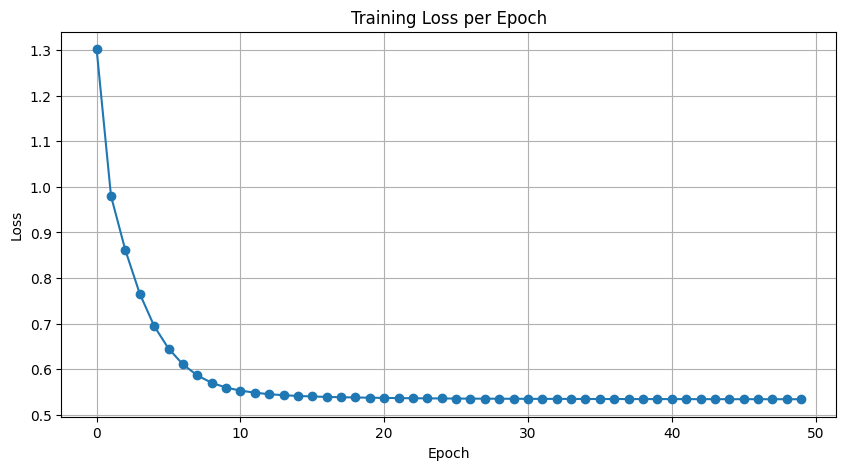

In [16]:
# plot losses
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(losses, marker='o')  # Plot losses, 'o' denotes the marker style
plt.title('Training Loss per Epoch')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.grid(True)  # Add
plt.show()

<Figure size 640x480 with 0 Axes>

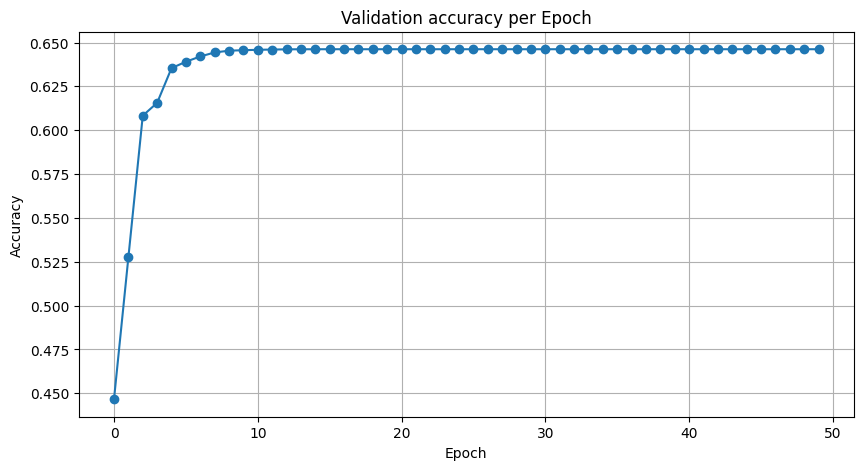

In [18]:
# plot validation accuracies
plt.clf()
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.plot(accuracies, marker='o')  # Plot losses, 'o' denotes the marker style
plt.title('Validation accuracy per Epoch')  # Title of the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Accuracy')  # Label for the y-axis
plt.grid(True)  # Add
plt.show()